<a href="https://colab.research.google.com/github/vsneelesh/BERT-Based-Sentiment-Analysis-with-Keyword-Extraction/blob/main/SurveySparrow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

import pandas as pd
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from gensim.models import FastText
import numpy as np
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
df = pd.read_csv('WCDataset.csv')

In [ ]:
df.head()

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


In [ ]:
#Creating a backup dataframe
df_backup = df.copy()

In [ ]:
# Step 4: Dropping unnecessary columns
columns_to_drop = ['Unnamed: 0', 'Clothing ID', 'Title']
df = df.drop(columns=columns_to_drop)

In [ ]:
df.head()

,Age,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,33,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,34,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,60,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,50,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,47,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


In [ ]:
# Step 5: Handle missing values
# Dropping rows with missing values in the 'Review Text' column
df = df.dropna(subset=['Review Text'])

In [ ]:
df.isnull().sum()

Age                         0
Review Text                 0
Rating                      0
Recommended IND             0
Positive Feedback Count     0
Division Name              13
Department Name            13
Class Name                 13
dtype: int64

In [ ]:
df = df.dropna()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22628 entries, 0 to 23485
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Age                      22628 non-null  int64 
 1   Review Text              22628 non-null  object
 2   Rating                   22628 non-null  int64 
 3   Recommended IND          22628 non-null  int64 
 4   Positive Feedback Count  22628 non-null  int64 
 5   Division Name            22628 non-null  object
 6   Department Name          22628 non-null  object
 7   Class Name               22628 non-null  object
dtypes: int64(4), object(4)
memory usage: 1.6+ MB


In [ ]:
from sklearn.preprocessing import LabelEncoder

#Storing the encoded variables in a different variable names so that We can retain the original
# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Apply LabelEncoder to each categorical column
df['Division Name Encoded'] = label_encoder.fit_transform(df['Division Name'])
df['Department Name Encoded'] = label_encoder.fit_transform(df['Department Name'])
df['Class Name Encoded'] = label_encoder.fit_transform(df['Class Name'])

# Display the first few rows of the dataframe after label encoding
print("Label Encoded DataFrame:")
print(df.head())

Label Encoded DataFrame:
   Age                                        Review Text  Rating  \
0   33  Absolutely wonderful - silky and sexy and comf...       4   
1   34  Love this dress!  it's sooo pretty.  i happene...       5   
2   60  I had such high hopes for this dress and reall...       3   
3   50  I love, love, love this jumpsuit. it's fun, fl...       5   
4   47  This shirt is very flattering to all due to th...       5   

   Recommended IND  Positive Feedback Count   Division Name Department Name  \
0                1                        0       Initmates        Intimate   
1                1                        4         General         Dresses   
2                0                        0         General         Dresses   
3                1                        0  General Petite         Bottoms   
4                1                        6         General            Tops   

  Class Name  Division Name Encoded  Department Name Encoded  \
0  Intimates         

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22628 entries, 0 to 23485
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Age                      22628 non-null  int64 
 1   Review Text              22628 non-null  object
 2   Rating                   22628 non-null  int64 
 3   Recommended IND          22628 non-null  int64 
 4   Positive Feedback Count  22628 non-null  int64 
 5   Division Name            22628 non-null  object
 6   Department Name          22628 non-null  object
 7   Class Name               22628 non-null  object
 8   Division Name Encoded    22628 non-null  int64 
 9   Department Name Encoded  22628 non-null  int64 
 10  Class Name Encoded       22628 non-null  int64 
dtypes: int64(7), object(4)
memory usage: 2.1+ MB


In [ ]:
#Preprocessing the ReviewText

import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer

import nltk
nltk.download('stopwords')
nltk.download('wordnet')

def clean_text(text):
   # Lowercase the text
    text = text.lower()

    # Remove digits
    text = re.sub(r'\d+', '', text)

    # Remove punctuation
    PUNCT_TO_REMOVE = string.punctuation
    text = ' '.join(text.translate(str.maketrans('', '', PUNCT_TO_REMOVE)).split())

    # Remove stopwords
    STOPWORDS = set(stopwords.words('english'))
    text = ' '.join([word for word in str(text).split() if word not in STOPWORDS])

    # Stem words
    stemmer = PorterStemmer()
    text = " ".join([stemmer.stem(word) for word in text.split()])

    # Lemmatize words
    lemmatizer = WordNetLemmatizer()
    text = " ".join([lemmatizer.lemmatize(word) for word in text.split()])

    return text.strip()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
df['Cleaned Review Text'] = df['Review Text'].apply(clean_text)

In [ ]:
print(df[['Cleaned Review Text']].head())

                                 Cleaned Review Text
0                  absolut wonder silki sexi comfort
1  love dress sooo pretti happen find store im gl...
2  high hope dress realli want work initi order p...
3  love love love jumpsuit fun flirti fabul everi...
4  shirt flatter due adjust front tie perfect len...


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Assuming 'df' is your existing dataframe
df['Keywords'] = ''

def extract_keywords(text):
    # Create TF-IDF vectorizer
    tfidf_vectorizer = TfidfVectorizer(max_features=10)  # Set max_features to the number of keywords you want

    # Fit-transform the preprocessed text
    tfidf_matrix = tfidf_vectorizer.fit_transform([text])

    # Get feature names (keywords)
    feature_names = tfidf_vectorizer.get_feature_names_out()

    return feature_names

# Apply keyword extraction to each row in the dataframe
for index, row in df.iterrows():
    keywords = extract_keywords(row['Cleaned Review Text'])
    df.at[index, 'Keywords'] = ', '.join(keywords)



In [ ]:
# Display the dataframe with extracted keywords
print(df.head())

   Age                                        Review Text  Rating  \
0   33  Absolutely wonderful - silky and sexy and comf...       4   
1   34  Love this dress!  it's sooo pretty.  i happene...       5   
2   60  I had such high hopes for this dress and reall...       3   
3   50  I love, love, love this jumpsuit. it's fun, fl...       5   
4   47  This shirt is very flattering to all due to th...       5   

   Recommended IND  Positive Feedback Count   Division Name Department Name  \
0                1                        0       Initmates        Intimate   
1                1                        4         General         Dresses   
2                0                        0         General         Dresses   
3                1                        0  General Petite         Bottoms   
4                1                        6         General            Tops   

  Class Name  Division Name Encoded  Department Name Encoded  \
0  Intimates                      2           

In [ ]:
df = df.dropna(subset=['Sentiment'])


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from gensim.models import FastText
import numpy as np
from sklearn.linear_model import LogisticRegression

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['Cleaned Review Text'], df['Sentiment'], test_size=0.2, random_state=42)

# Train FastText model
ft_model = FastText(sentences=X_train, vector_size=100, window=5, min_count=1, workers=4, sg=1)

# Get sentence embeddings
def get_sentence_embedding(sentence, model):
    words = sentence.split()
    embeddings = [model.wv[word] for word in words if word in model.wv]
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(model.vector_size)

# Generate embeddings for training and testing data
X_train_ft = np.array([get_sentence_embedding(sentence, ft_model) for sentence in X_train])
X_test_ft = np.array([get_sentence_embedding(sentence, ft_model) for sentence in X_test])

# Use any classification algorithm (e.g., Logistic Regression) for sentiment classification
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train_ft, y_train)

# Predict sentiment on the test data
y_pred = lr_model.predict(X_test_ft)

# Calculate accuracy and print classification report
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print(classification_report(y_test, y_pred))

# Add the predicted sentiment column to the DataFrame
df['Predicted Sentiment'] = lr_model.predict(np.array([get_sentence_embedding(sentence, ft_model) for sentence in df['Cleaned Review Text']]))

# Display the updated DataFrame
print(df.head())


Accuracy: 0.999448275862069
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         2
         1.0       1.00      1.00      1.00      3623

    accuracy                           1.00      3625
   macro avg       0.50      0.50      0.50      3625
weighted avg       1.00      1.00      1.00      3625



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


   Age                                        Review Text  Rating  \
0   33  Absolutely wonderful - silky and sexy and comf...       4   
1   34  Love this dress!  it's sooo pretty.  i happene...       5   
2   60  I had such high hopes for this dress and reall...       3   
3   50  I love, love, love this jumpsuit. it's fun, fl...       5   
4   47  This shirt is very flattering to all due to th...       5   

   Recommended IND  Positive Feedback Count   Division Name Department Name  \
0                1                        0       Initmates        Intimate   
1                1                        4         General         Dresses   
2                0                        0         General         Dresses   
3                1                        0  General Petite         Bottoms   
4                1                        6         General            Tops   

  Class Name  Division Name Encoded  Department Name Encoded  \
0  Intimates                      2           

In [ ]:
columns_to_drop = ['Division Name','Department Name','Class Name','Review Text','Predicted Sentiment']

df = df.drop(columns=columns_to_drop)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18122 entries, 0 to 18805
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      18122 non-null  int64  
 1   Rating                   18122 non-null  int64  
 2   Recommended IND          18122 non-null  int64  
 3   Positive Feedback Count  18122 non-null  int64  
 4   Division Name Encoded    18122 non-null  int64  
 5   Department Name Encoded  18122 non-null  int64  
 6   Class Name Encoded       18122 non-null  int64  
 7   Cleaned Review Text      18122 non-null  object 
 8   Keywords                 18122 non-null  object 
 9   Sentiment                18122 non-null  float64
dtypes: float64(1), int64(7), object(2)
memory usage: 1.5+ MB


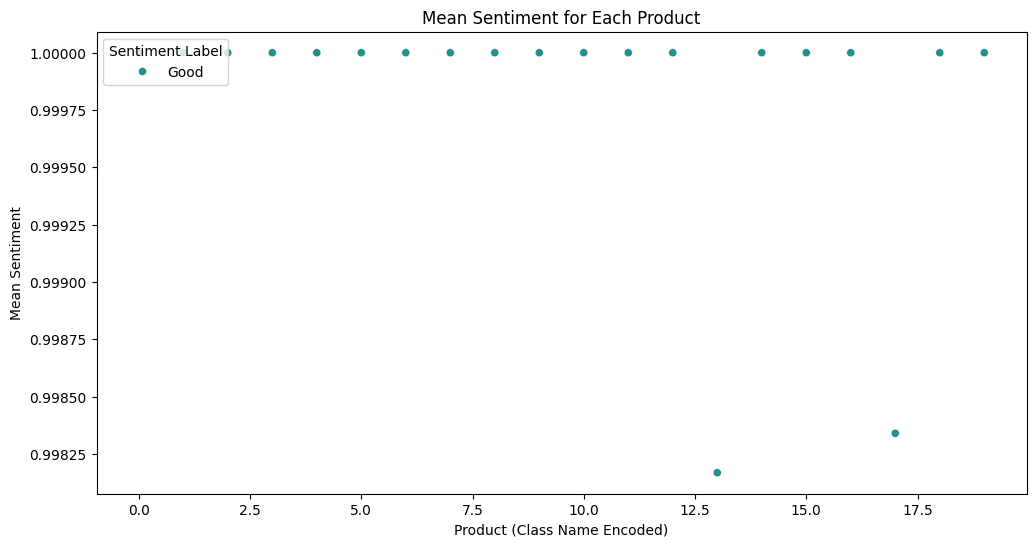

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df is your DataFrame containing sentiment data with columns 'Class Name Encoded' and 'Sentiment'
# Assuming you have already defined the get_sentiment_label function

# Group by product (Class Name Encoded) and calculate mean sentiment
product_sentiment = df.groupby('Class Name Encoded')['Sentiment'].mean().reset_index()

# Define sentiment labels
def get_sentiment_label(sentiment):
    if 0.9 <= sentiment < 0.99:
        return 'Neutral'
    elif sentiment >= 0.99:
        return 'Good'
    else:
        return 'Bad'

product_sentiment['Sentiment_Label'] = product_sentiment['Sentiment'].apply(get_sentiment_label)

# Create scatter plot
plt.figure(figsize=(12, 6))
sns.scatterplot(x='Class Name Encoded', y='Sentiment', data=product_sentiment, hue='Sentiment_Label', palette='viridis')
plt.xlabel('Product (Class Name Encoded)')
plt.ylabel('Mean Sentiment')
plt.title('Mean Sentiment for Each Product')
plt.legend(title='Sentiment Label', loc='upper left')
plt.show()


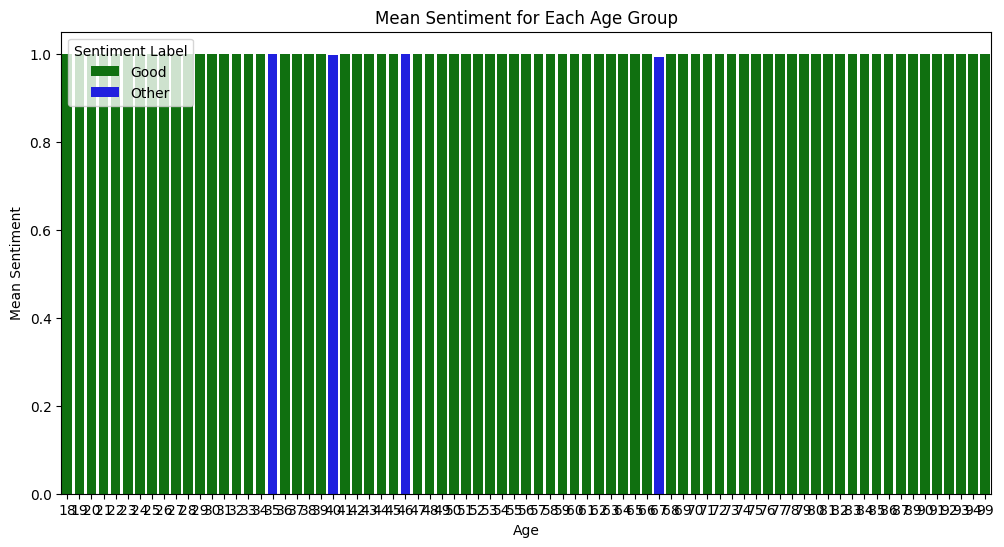

In [ ]:
# Group by age and calculate mean sentiment
age_sentiment = df.groupby('Age')['Sentiment'].mean().reset_index()

# Define sentiment labels
def get_sentiment_label(sentiment):
    if 0.9 <= sentiment < 0.99:
        return 'Bad'
    elif sentiment == 1:
        return 'Good'
    else:
        return 'Other'

age_sentiment['Sentiment_Label'] = age_sentiment['Sentiment'].apply(get_sentiment_label)

# Visualize the data
plt.figure(figsize=(12, 6))
sns.barplot(x='Age', y='Sentiment', data=age_sentiment, hue='Sentiment_Label', palette={'Bad': 'red', 'Good': 'green', 'Other': 'blue'})
plt.xlabel('Age')
plt.ylabel('Mean Sentiment')
plt.title('Mean Sentiment for Each Age Group')
plt.legend(title='Sentiment Label', loc='upper left')
plt.show()


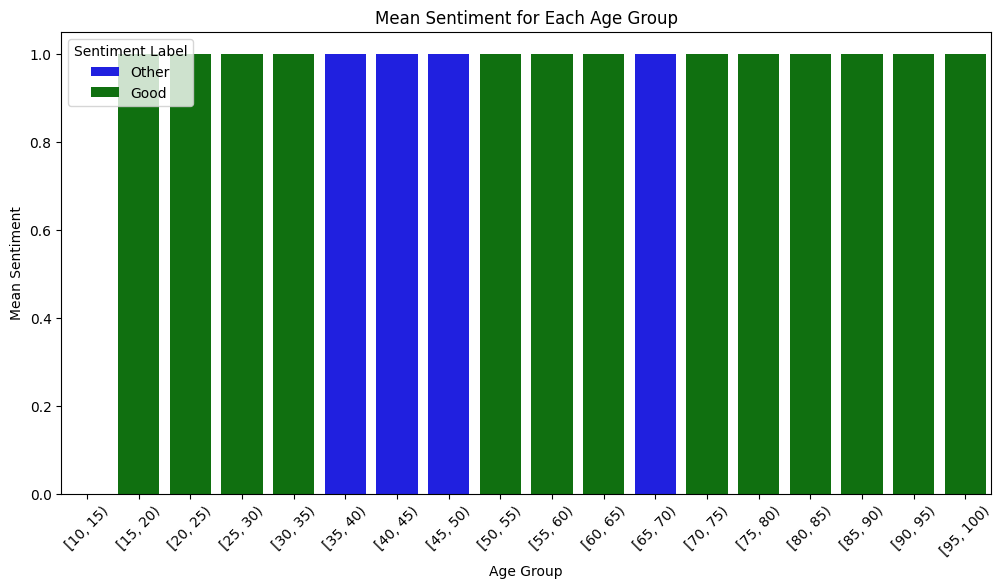

In [ ]:
# Define the age bins
bins = [10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]

# Create age groups
df['Age Group'] = pd.cut(df['Age'], bins=bins, right=False)

# Group by age group and calculate mean sentiment
age_group_sentiment = df.groupby('Age Group')['Sentiment'].mean().reset_index()

# Define sentiment labels
def get_sentiment_label(sentiment):
    if 0.9 <= sentiment < 0.99:
        return 'Bad'
    elif sentiment == 1:
        return 'Good'
    else:
        return 'Other'

age_group_sentiment['Sentiment_Label'] = age_group_sentiment['Sentiment'].apply(get_sentiment_label)

# Visualize the data
plt.figure(figsize=(12, 6))
sns.barplot(x='Age Group', y='Sentiment', data=age_group_sentiment, hue='Sentiment_Label', palette={'Bad': 'red', 'Good': 'green', 'Other': 'blue'})
plt.xlabel('Age Group')
plt.ylabel('Mean Sentiment')
plt.title('Mean Sentiment for Each Age Group')
plt.xticks(rotation=45)
plt.legend(title='Sentiment Label', loc='upper left')
plt.show()


<ipython-input-39-b242ee69b1df>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Rating', y='Sentiment', data=rating_sentiment, palette='viridis')


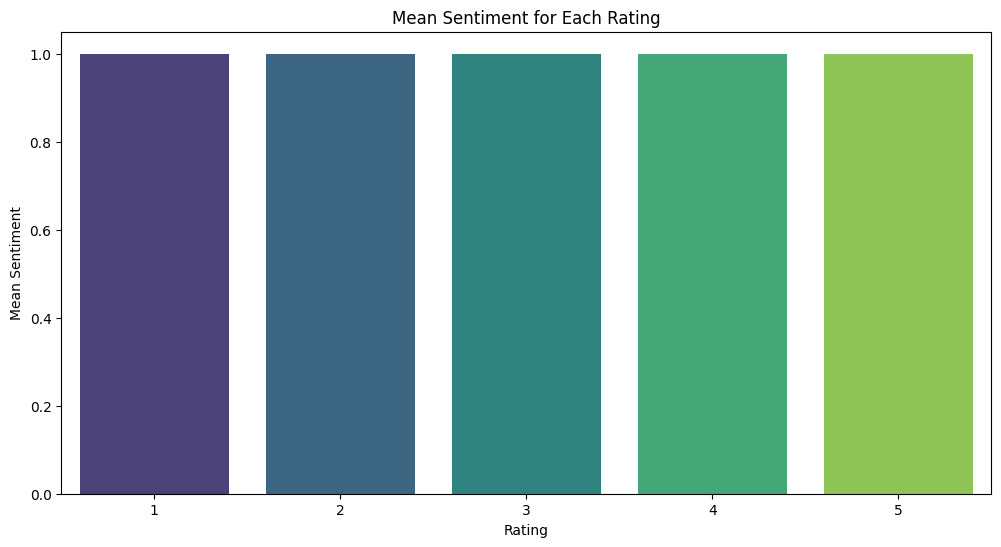

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df is your DataFrame containing sentiment data with columns 'Rating' and 'Sentiment'

# Group by rating and calculate mean sentiment
rating_sentiment = df.groupby('Rating')['Sentiment'].mean().reset_index()

# Visualize the data
plt.figure(figsize=(12, 6))
sns.barplot(x='Rating', y='Sentiment', data=rating_sentiment, palette='viridis')
plt.xlabel('Rating')
plt.ylabel('Mean Sentiment')
plt.title('Mean Sentiment for Each Rating')
plt.show()


In [ ]:
# Example for 'Division Name Encoded' column
encoded_values = df['Division Name Encoded'].unique()
decoded_values = label_encoder.inverse_transform(encoded_values)

# Create a dictionary to map encoded values to decoded values
encoded_decoded_map = dict(zip(encoded_values, decoded_values))

# Print the mapping
print("Encoded to Decoded Mapping for 'Division Name Encoded':")
print(encoded_decoded_map)


Encoded to Decoded Mapping for 'Division Name Encoded':
{2: 'Chemises', 0: 'Blouses', 1: 'Casual bottoms'}
